![intro](./intro.png)

# Project III. Face Detection and Swap with OpenCV+Dlib
1. Extract faces from a given image (68 landmarks detection)
2. Mesh the faces from two different images
3. Swap the faces of 2 persons

**The code implementation of Face Swap is written by students, while all visualization codes are provided.**

## Setup
Please install required packages and make sure the version are valid 

Installation of dlib library is bit tricky you have to follow some steps:
1. Install **visual studio (2017 or 2022)** - refer to this [link](https://visualstudio.microsoft.com/zh-hans/downloads/)
2. In visual studio one need to install CMake package
3. After installation from Visual studio we have to install it again using - `pip install cmake`
4. Here comes the last part now, we have to install dlib by - `pip install dlib`

### We will start by importing some required libraries.

In [1]:
import cv2
import numpy as np
import dlib
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

### Next we will load two images of different persons, resizing them to (300, 300).

In [2]:
grouppath = 'group1'

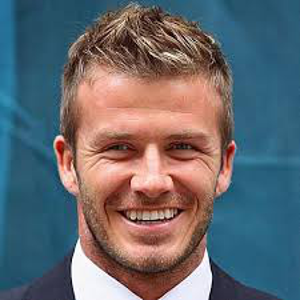

In [3]:
image1 = Image.open('../data' + '//' + grouppath +'//' + 'person1.jpg')
# group1:(300,300),group2(220,300),group3(290,400),group4(195,260)
image1 = image1.resize((300,300))  # if you change group, this size may need to be changed
image1

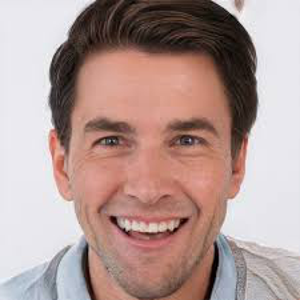

In [4]:
image2 = Image.open('../data' + '//' +grouppath +'//' + 'person2.jpg')
image2 = image2.resize((image1.size[0],image1.size[1]))
image2

### Now we will convert our images into numpy array and use cv2 to convert it into grayscale. We will also create empty image or mask similar to our source image with zeros.

In [5]:
# Converting image to array and converting them to grayscale
img1 = np.array(image1)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

### Load Face detector and Face landmarks predictor using dlib.

In [6]:
# Initalizing frontal face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../data/pretrained_weights/shape_predictor_68_face_landmarks.dat")

Code implemented by students in `student.py`:
1. the `get_landmarks()` first use `detector` to localize face bbox and then use `predictor` to detect landmarks (68 points, dtype: np.array).
2. the `get_face_mask()` gets the face mask according to landmarks.
3. the `get_delaunay_triangulation()` gets the face mesh triangulation according to landmarks.

In [7]:
from student import get_landmarks, get_face_mask, get_delaunay_triangulation, show_landmarks

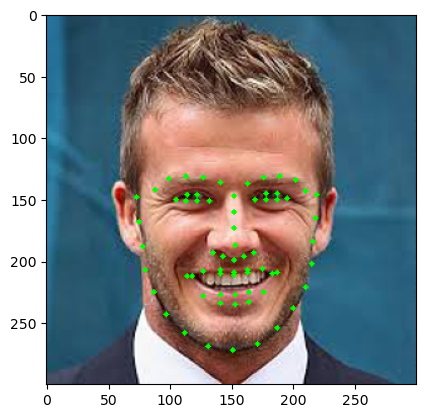

In [8]:
# Face 1
landmarks1 = get_landmarks(detector, predictor, img1_gray)
show_landmarks(img1, landmarks1)

# Mask
convexhull1, mask1 = get_face_mask(img1_gray, landmarks1)
face1 = cv2.bitwise_and(img1, img1, mask=mask1[:,:,0])

# Delaunay triangulation
triangles1 = get_delaunay_triangulation(landmarks1, convexhull1)

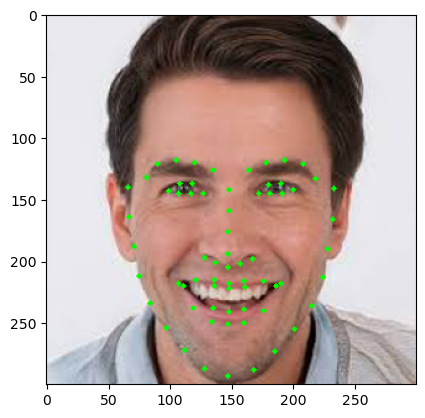

In [9]:
# Face 2
landmarks2 = get_landmarks(detector, predictor, img2_gray)
show_landmarks(img2, landmarks2)

# Mask
convexhull2, mask2 = get_face_mask(img2_gray, landmarks2)

# Delaunay triangulation
triangles2 = get_delaunay_triangulation(landmarks2, convexhull2)

### Face Detection and Landmark Detection Visualization

In [10]:
def visulize_face_landmarks(img, mask, landmarks, triangles):
    plt.figure(figsize=(100, 300))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
 
    
    plt.subplot(1, 3, 2)
    face = cv2.bitwise_and(img, img, mask=mask[:,:,0])
    plt.imshow(face)
    plt.axis('off')
 
    
    plt.subplot(1, 3, 3)
    img_landmark = img.copy()
    
    for triangle in triangles:
        cv2.polylines(img_landmark, [np.array(triangle, np.int32).reshape((-1, 1 ,2))], True, (254, 254, 254), 1)
    for i, xy in enumerate(landmarks):
        x = xy[0, 0]
        y = xy[0, 1]
        cv2.circle(img_landmark, (x, y), 3, (0, 255, 0), -1)

    
    plt.imshow(img_landmark)
    plt.axis('off')
    
    plt.show()

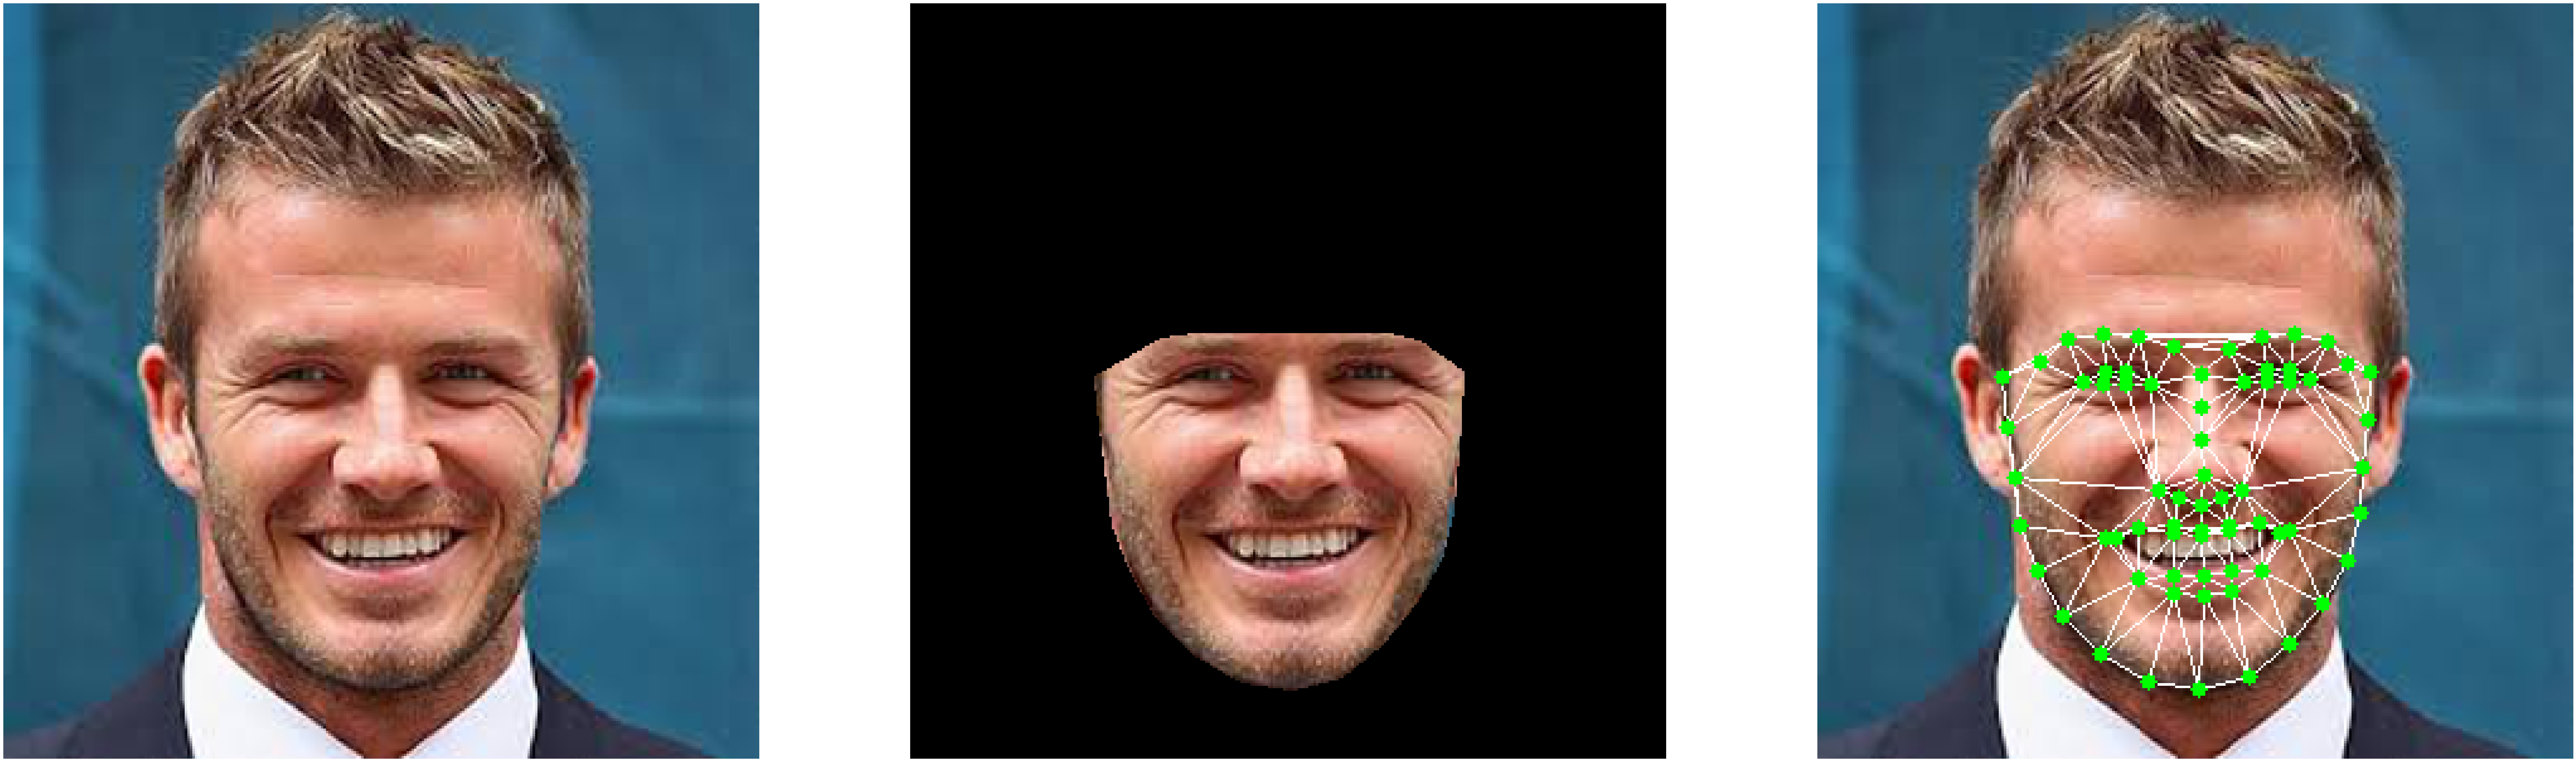

In [11]:
visulize_face_landmarks(img1, mask1, landmarks1, triangles1)

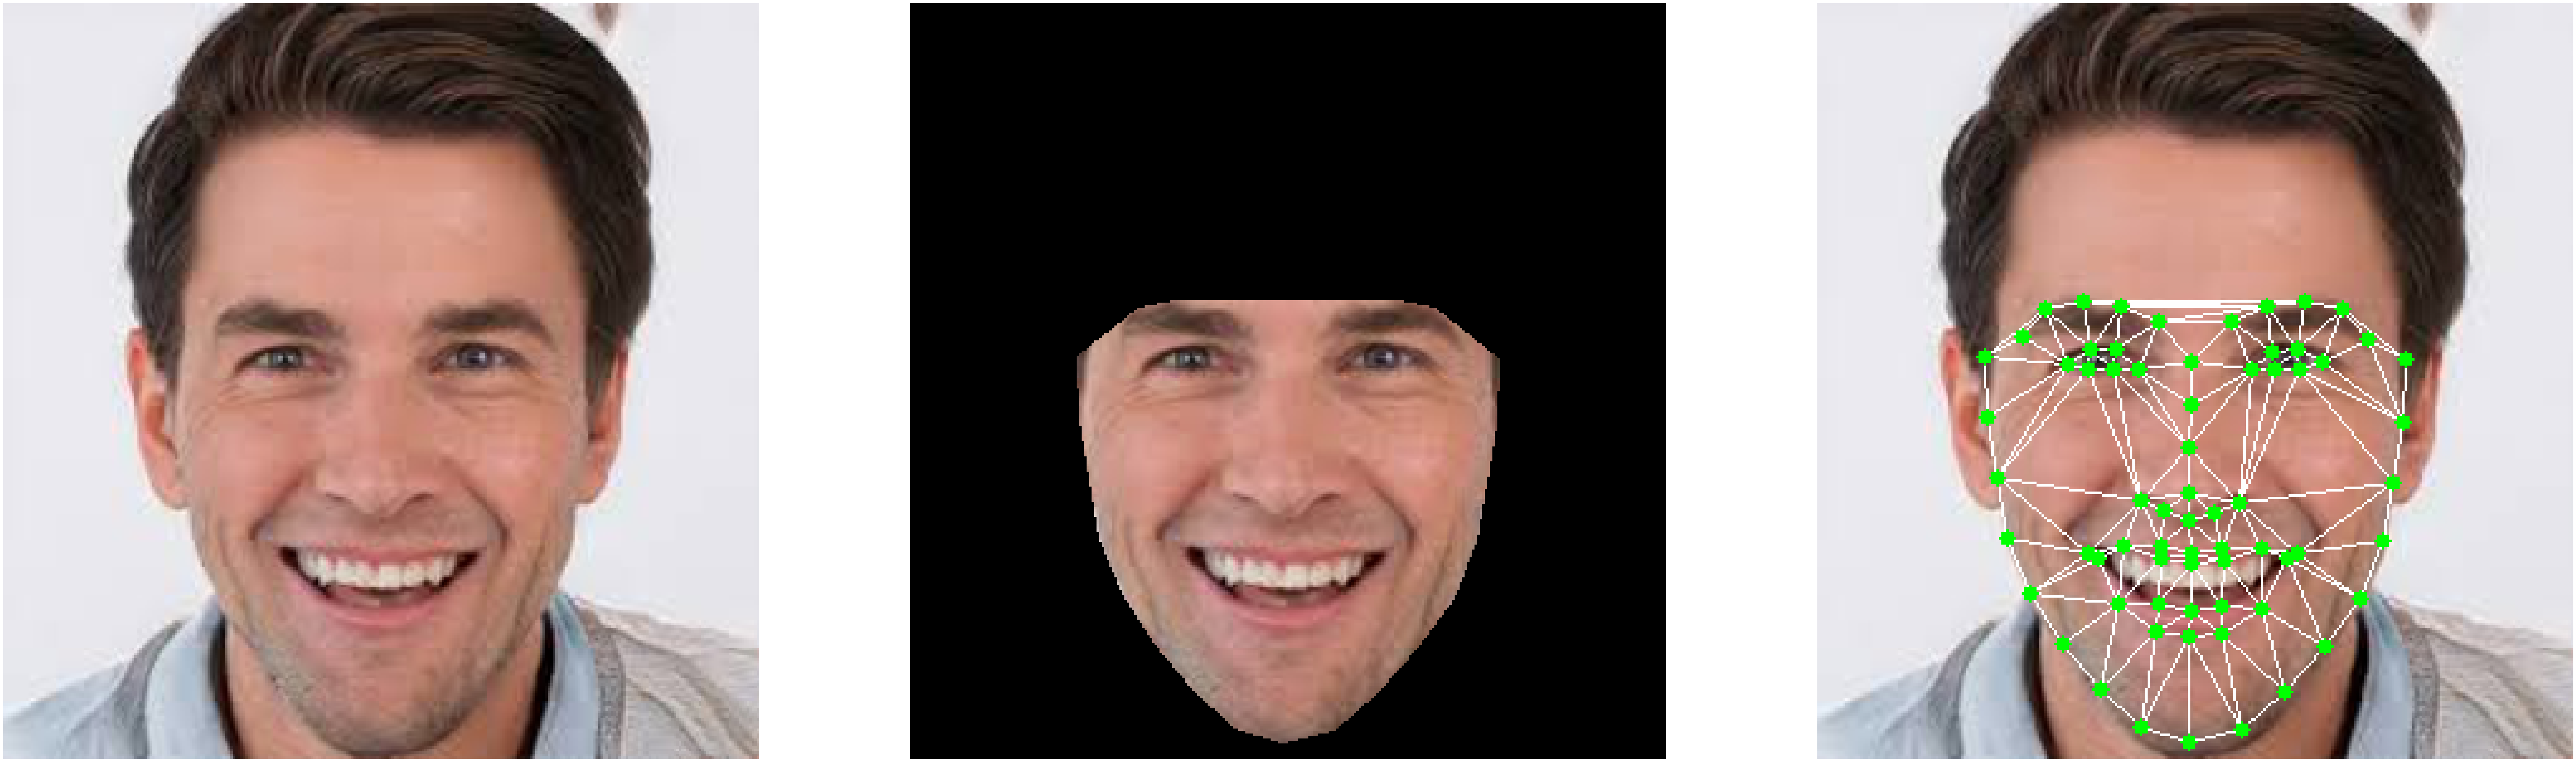

In [12]:
visulize_face_landmarks(img2, mask2, landmarks2, triangles2)

### Now, let us swap the source face (person1 in example) to target image (person2 in example).
Code implemented by students in `student.py`:
1. `transformation_from_points()` calculate the affine transformation matrix M to warp the face of person2 to match person1.
2. `warp_img()` utilize the affine transformation matrix M to transform the img.

In [13]:
from student import transformation_from_landmarks, warp_img, correct_colours

### swap the face of person1 to match person2

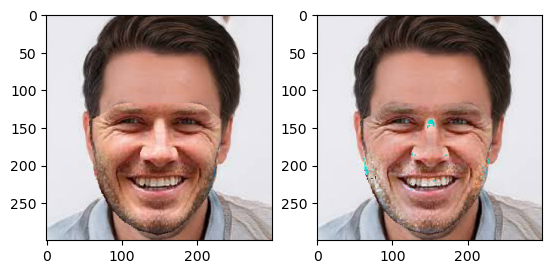

In [14]:
'''
img2: target img (person2)
warped_img1: warped face img of person1
face_mask1: warped face mask of person1
'''
#TODO: Implement this function!
M = transformation_from_landmarks(landmarks2, landmarks1)

conv, mask1 = get_face_mask(img1, landmarks1)  # convexhull is useless here
warped_mask1 = warp_img(mask1, M, img2.shape)
conv, mask2 = get_face_mask(img2, landmarks2)
combined_mask = np.max([mask2, warped_mask1], axis=0)
warped_im1 = warp_img(img1, M, img2.shape)
warped_corrected_im1 = correct_colours(img2, warped_im1, landmarks2)

output_img = img2 * (1.0 - combined_mask) + warped_im1 * combined_mask  # face swap
output_img = output_img.astype(np.uint8)  # convert to uint8
plt.subplot(1, 2, 1)
plt.imshow(output_img)
output_img_color = img2 * (1.0 - combined_mask) + warped_corrected_im1 * combined_mask  # face swap
output_img_color = output_img_color.astype(np.uint8)  # convert to uint8
plt.subplot(1, 2, 2)
plt.imshow(output_img_color)

### (Optional) On Opencv we have a built-in function called “seamlessClone” that does this operation automatically. We need to take the swapped face, take the original destination image and it’s mask to cut out the face, we need to get the center of the face.

In [15]:
warped_corrected_im1 = warped_corrected_im1.astype(np.uint8)  # convert to uint8

[[148 190]]


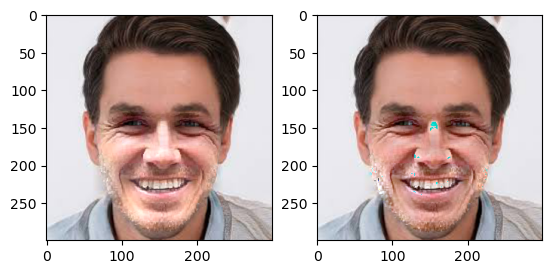

In [17]:
#TODO: Implement this function!
newmask = warped_mask1.astype(np.uint8)
newmask[newmask != 0] = 255
# Get the center of mask2
center = np.mean(1, axis=0)
center = center.astype(np.int32)
print(center)
# Seamless fusion with seamlessClone function
# Note you should set the center of the face according to the center of the mask, but it is not totally equal to the center of the mask.
delta_x = 0  # Your correction value, delta_x < 0: left, delta_x > 0: right
delta_y = 20  # delta_y < 0: up, delta_y > 0: down
x = center[0,0] + delta_x
y = center[0,1] + delta_y
# warped_corrected_im1 means color correction, warped_im1 means no color correction
plt.subplot(1, 2, 1)
seamlessclone = cv2.seamlessClone(warped_im1, img2, newmask, (x, y),  cv2.NORMAL_CLONE)
plt.imshow(seamlessclone)
plt.subplot(1, 2, 2)
seamlessclone = cv2.seamlessClone(warped_corrected_im1, img2, newmask, (x, y),  cv2.NORMAL_CLONE)
plt.imshow(seamlessclone)